## Controller for path following

The theroy behind the code has as reference the following lecture of ETH: https://ethz.ch/content/dam/ethz/special-interest/mavt/robotics-n-intelligent-systems/asl-dam/documents/lectures/autonomous_mobile_robots/spring-2021/3%20ETH%20Lecture%20%20Mobile%20Robots%20Kinematics%20add%20ons%202021%20RS.pdf  
The code comes from the Matlab code of the resolution Exercise 2 at this link : https://asl.ethz.ch/education/lectures/autonomous_mobile_robots/spring-2021.html

<img src="kalman\Controller_scheme.png" width="600" height="300">

The image above represents the quantities used by the controller:
* $ \rho $ is the distance between Thymio and the goal position (not necessarily the global one);
* $ \alpha $ is the difference between the current angle of Thymio and the angle it should have to reach the next goal;
* $ \beta $ is the angle between Thymio's position and the goal position plus the goal angle;
* $ v $ is Thymio's forward velocity, one of the outputs of the control law;
* $ \omega $ is Thymio's rotational velocity, one of the outputs of the control law.


We first planned to do a closed loop proportional controller as the image shows: 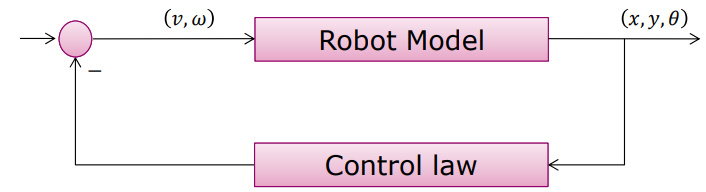

The resulting controller is a K matrix: 
$$
K =
\begin{bmatrix}
k_{11} & k_{12} & k_{13} \\
k_{21} & k_{22} & k_{23}
\end{bmatrix}
$$
 that has the goal to drive the state error to zero. It is a MIMO state feedback control
$$
\begin{bmatrix}
v(t) \\
\omega(t)
\end{bmatrix}
= K \cdot e = K \cdot
\begin{bmatrix}
x \\
y \\
\theta
\end{bmatrix}^R
$$

$$
\lim_{{t \to \infty}} e(t) = 0
$$

The controller has then been semplified by using a constant forward velocity. In fact, if v is proportional to the error in position, we will not have a smooth path following: in every little segment we would obtain acceleration and decelerations due to the change in velocity. High speed at the beginning and really low at the end. We then decided not to control forward velocity (to open the loop) leaving it constant. However we control the direction of movement through angular velocity.

The following is the final controller:


$$
v(t) = K_v
$$

$$
\omega(t)
= K_\omega \cdot e = K_\omega \cdot
\begin{bmatrix}
x \\
y \\
\theta
\end{bmatrix}^R
$$

where

K_v is a constant forward velocity and

$$
K_\omega =
\begin{bmatrix}
k_{21} & k_{22} & k_{23}
\end{bmatrix}
$$





In [53]:
import math
import numpy as np

def get_theta_goal(x_goal, y_goal, x_next = [] , y_next = []):
     # This function calculates the angle between the current position and the next goal
     # This angle is used to calculate the angle alpha in the control law
     # The angle is calculated using the arctan function
     # The angle is calculated in radians
     # The angle is returned as a positive value between 0 and 360 degrees
     if x_next == [] and y_next == []:
          theta_goal = math.atan2(y_goal, x_goal) 
     else:
          theta_goal = math.atan2(y_goal - y_next, x_goal - x_next) 
          
     return theta_goal


def control_law(state_estimate_k, x_goal, y_goal, theta_goal,  constant_speed = 0.1536, Kp_alpha = 2 , Kp_beta = -0.5):
     #the current position estimate (x,y and theta) from the filter is defined 
     x = state_estimate_k[0]
     y = state_estimate_k[1]
     theta = state_estimate_k[2]
     """
     -->alpha is the angle to the goal relative to the heading of the robot
     -->beta is the angle between the robot's position and the goal position plus the goal angle
     -->Kp_rho*rho and Kp_alpha*alpha drive the robot along a line towards the goal
     -->Kp_beta*beta rotates the line so that it is parallel to the goal angle
    
     """
     
     #the current position estimate (x,y and theta) from the filter is defined 
     x = state_estimate_k[0]
     y = state_estimate_k[1]
     theta = state_estimate_k[2]

     #the difference between current position and the next goal is defined. 
     #It is important to notice that the goal defined here is not necessarily the final goal. 
     #The goal is the next point on the discretised path 
     x_diff = x_goal - x
     y_diff = y_goal - y

     

     # Restrict alpha and beta (angle differences) to the range
     # [-pi, pi] to prevent unstable behavior e.g. difference going
     # from 0 rad to 2*pi rad with slight turn


     # alpha is the calculated as the difference in angles between the current angle and the angle that it should 
     #  have to reach the next goal. It accounts for the multiples of 2*pi and resistricts the angle between -pi & pi
     # In this step, we calculate the angle diffrence between where the robot is going and its current position
     alpha = (math.atan2(y_diff, x_diff) - theta + math.pi) % (2 * math.pi) - math.pi
     #-->math.atan2(y_diff, x_diff): This calculates the angle in radians between the positive x-axis and the point (x_diff, y_diff). 
     # It's a way to calculate the angle considering the quadrant where the point is located.
     #--> - theta: This subtracts theta from the angle calculated above. theta is typically an existing angle or orientation you are comparing against.
     #-->+ math.pi: Adding π (pi) radians (or 180 degrees) is a common technique to shift the range of the result. atan2 returns values in the range [-π, π], and by adding π, you shift this to [0, 2π].
     #--> % (2 * math.pi): The modulo operation with 2π ensures that the result stays within the range [0, 2π]. This is a common technique to normalize angles.
     #--> - math.pi: Finally, subtracting π shifts the range back to [-π, π].

     #This expression normalizes angles by shifting them into the 0 to 2π range for a modulo operation, and then back to the -π to π range,
     #ensuring angles like 405 degree, for example, s are correctly interpreted as 45 degrees.

     # the beta is calculating the difference the in angle to the goal (next node). Similar to alpha, 
     # multiples of 2*pi are accounted for and beta is resistricted between -pi and pi.
     # In this step, we calculate the angle needed to achieve the goal orientation
     #beta = (theta_goal - theta - alpha + math.pi) % (2 * math.pi) - math.pi

     v = constant_speed
     # The angular velocity is calculated based on the previously defined angles beta and alpha with each of them 
     #multiplied by a gain. The gain values are different than the ones used by the source to match our application
     w = Kp_alpha * alpha #+ Kp_beta * beta

     # The control function returns the linear and angular velocities computed which will then be converted to Thymio 
     # speeds to be input to the motors
     return v,w



# Function to get B matrix
def getB(yaw, deltak):
    B = np.array([[np.cos(yaw) * deltak, 0],
                  [np.sin(yaw) * deltak, 0],
                  [0, deltak]])
    return B


<img src="kalman\Controller_scheme.png" width="600" height="300">


C:\Users\elisa\AppData\Local\Temp\ipykernel_8292\3701208315.py:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if x_next == [] and y_next == []:


[ 0.75941978  0.58601416  0.17672527 -0.34585497 -0.66915549 -0.777099
 -0.72185882 -0.47350763  0.00970681  0.00970681]
[[0.2 0. ]
 [0.  0. ]
 [0.  0.2]]
[[0.19084324 0.        ]
 [0.05982354 0.        ]
 [0.         0.2       ]]
[[0.17576515 0.        ]
 [0.09542856 0.        ]
 [0.         0.2       ]]
[[0.16259458 0.        ]
 [0.1164603  0.        ]
 [0.         0.2       ]]
[[0.15277407 0.        ]
 [0.12907394 0.        ]
 [0.         0.2       ]]
[[0.14590259 0.        ]
 [0.1367934  0.        ]
 [0.         0.2       ]]
[[0.14123453 0.        ]
 [0.14160794 0.        ]
 [0.         0.2       ]]
[[0.13810789 0.        ]
 [0.14465895 0.        ]
 [0.         0.2       ]]
[[0.13602655 0.        ]
 [0.1466178  0.        ]
 [0.         0.2       ]]
[[0.13464316 0.        ]
 [0.14788921 0.        ]
 [0.         0.2       ]]
[[0.13372239 0.        ]
 [0.1487223  0.        ]
 [0.         0.2       ]]
[[0.13310738 0.        ]
 [0.14927299 0.        ]
 [0.         0.2       ]]
[[0.13269

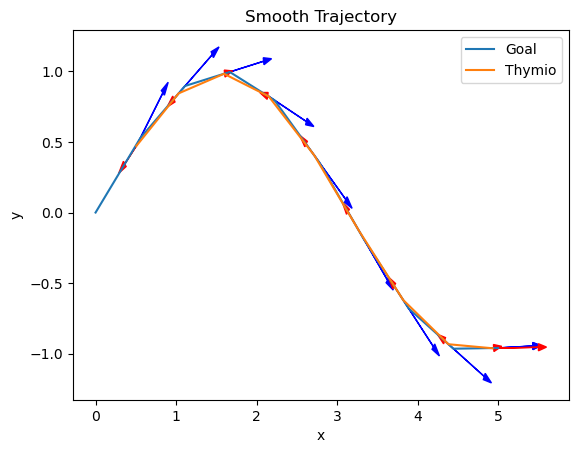

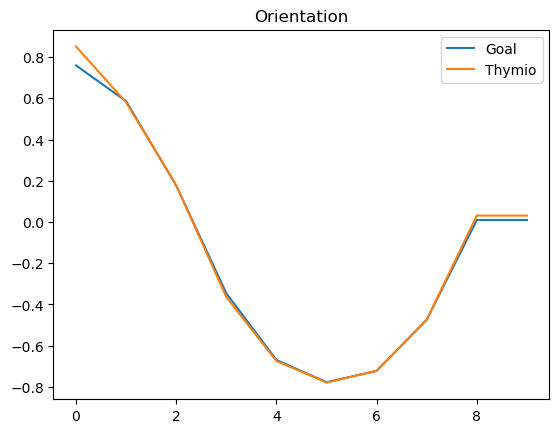

In [118]:
import matplotlib.pyplot as plt
import time

#-------------PARAMETERS FOR THE SIMULATION-----------------
#Conversion coefficients from Thymio to radians per second
C_conv_toThymio_right = 67.60908181
C_conv_toThymio_left = 67.82946137

#Simulation parameters
N= 10 # number of nodes
T = 0.2 # time step

#Thymio parameters:
R = 20 #mm
L = 104 #mm

#Threshold for convergence
threshold_for_convergence = 0.1 #mm

#---------------------exemple trajectory for the Thymio to follow---------------------
#  --> normally given by the global planner
x_goal = np.linspace(0, 5, N)
y_goal = np.sin(x_goal)
theta_goal = np.zeros(N)
for i in range(len(x_goal)-1):
    theta_goal[i] = get_theta_goal(x_goal[i], y_goal[i], x_goal[i+1], y_goal[i+1])
theta_goal[len(x_goal)-1] = theta_goal[len(x_goal)-2]
theta_goal= theta_goal %(2 * math.pi) - math.pi
print(theta_goal)



# Assuming 'N' is defined elsewhere and 'parameters' is a defined dictionary with appropriate keys
# Also assuming 'calculateWheelSpeeds' is a defined function that returns left and right wheel velocities
# v and omega need to be defined or calculated before the loop starts


parameters = {
    'wheelRadius': R,  
    'interWheelDistance': L  
}
v = 0.0  # Initialize linear velocity
omega = 0.0  # Initialize angular velocity


X= np.zeros((3, N))
X[:, 0] = [0.2, 0.1, np.pi/4] # initial state
X[:,0] = [0, 0, 0]
A = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]) # state transition matrix


for i in range(1, N):
    convergence = False
    while convergence == False:
        # Calculate the control inputs
        v, omega = control_law(X[:, i-1], x_goal[i], y_goal[i], theta_goal[i], constant_speed = 0.1536, Kp_alpha = 2 , Kp_beta = -0.5)
        
        # Calculate the next state (in practice it will be iven my the  kalman filter)
        u = np.array([v, omega])
        u = u.transpose()
        B = getB(X[2, i-1], T)
        print(B)
        X[:, i-1] = A @ X[:, i-1] + B @ u
        if np.linalg.norm(X[:2, i-1] - np.array([x_goal[i], y_goal[i]])) < threshold_for_convergence:
            convergence = True
            X[:,i] = X[:, i-1]
        #wait T seconds:
        #time.sleep(T)

    


# Plotting the points to visualize the trajectory
plt.plot(x_goal, y_goal)
plt.plot(X[0, :], X[1, :])
plt.title('Smooth Trajectory')
plt.legend(['Goal', 'Thymio'])
plt.xlabel('x')
plt.ylabel('y')
# Plotting the orientation lines
line_length = 0.5
# Plotting the actual orientation lines
for i in range(len(X[2, :])):
    # End point of the actual orientation line
    actual_end_x = X[0, i] + line_length * np.cos(X[2, i])
    actual_end_y = X[1, i] + line_length * np.sin(X[2, i])

    # Draw an arrow for actual orientation
    plt.arrow(X[0, i], X[1, i], actual_end_x - X[0, i], actual_end_y - X[1, i], 
              head_width=0.05, head_length=0.1, fc='blue', ec='blue')

# Plotting the desired orientation lines
for i in range(len(theta_goal)):
    # End point of the desired orientation line
    desired_end_x = x_goal[i] + line_length * np.cos(theta_goal[i])
    desired_end_y = y_goal[i] + line_length * np.sin(theta_goal[i])

    # Draw an arrow for desired orientation
    plt.arrow(X[0, i], X[1, i], desired_end_x - X[0, i], desired_end_y - X[1, i], 
              head_width=0.05, head_length=0.1, fc='red', ec='red')

    
plt.show()

#Plot in anther fiure the orientation oal an actual
plt.plot(theta_goal)
plt.plot(X[2, :])
plt.title('Orientation')
plt.legend(['Goal', 'Thymio'])
plt.xlabel('')
plt.show()

C:\Users\elisa\AppData\Local\Temp\ipykernel_8292\3701208315.py:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if x_next == [] and y_next == []:


[ 1.42941649 -1.4790432  -1.37929594  1.11037955  1.44105953  1.36020763
 -1.44487279  1.35293539 -1.47783062 -1.47783062]
[[0.2 0. ]
 [0.  0. ]
 [0.  0.2]]
[[0.16445717 0.        ]
 [0.11381493 0.        ]
 [0.         0.2       ]]
[[0.11308069 0.        ]
 [0.1649629  0.        ]
 [0.         0.2       ]]
[[0.07441101 0.        ]
 [0.18564213 0.        ]
 [0.         0.2       ]]
[[0.04923597 0.        ]
 [0.19384483 0.        ]
 [0.         0.2       ]]
[[0.03360587 0.        ]
 [0.1971564  0.        ]
 [0.         0.2       ]]
[[0.02406791 0.        ]
 [0.19854656 0.        ]
 [0.         0.2       ]]
[[0.0182861  0.        ]
 [0.19916229 0.        ]
 [0.         0.2       ]]
[[0.0147906  0.        ]
 [0.19945235 0.        ]
 [0.         0.2       ]]
[[0.01267973 0.        ]
 [0.19959766 0.        ]
 [0.         0.2       ]]
[[0.01140565 0.        ]
 [0.19967451 0.        ]
 [0.         0.2       ]]
[[0.01063683 0.        ]
 [0.19971694 0.        ]
 [0.         0.2       ]]
[[0.010

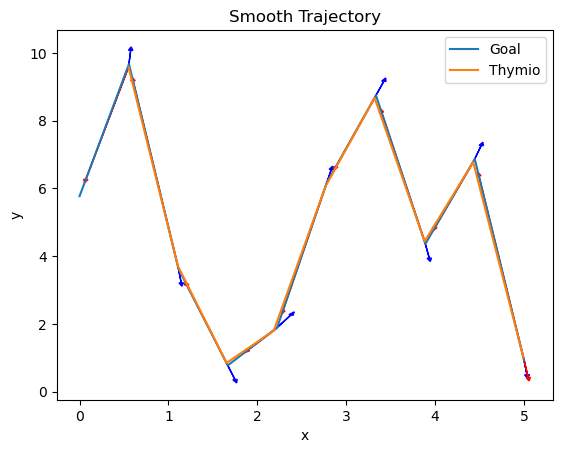

In [123]:
#---------------------exemple2 trajectory for the Thymio to follow---------------------
#  --> normally given by the global planner
x_goal = np.linspace(0, 5, N)
y_goal = np.random.rand(N)*10
theta_goal = np.zeros(N)
for i in range(len(x_goal)-1):
    theta_goal[i] = get_theta_goal(x_goal[i], y_goal[i], x_goal[i+1], y_goal[i+1])
theta_goal[len(x_goal)-1] = theta_goal[len(x_goal)-2]
theta_goal= theta_goal %(2 * math.pi) - math.pi
print(theta_goal)




#-----copy paste of the previous code for trajectory simulation---------------
v = 0.0  # Initialize linear velocity
omega = 0.0  # Initialize angular velocity


X= np.zeros((3, N))
X[:, 0] = [0.2, 0.1, np.pi/4] # initial state
X[:,0] = [0, 0, 0]
A = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]) # state transition matrix


for i in range(1, N):
    convergence = False
    while convergence == False:
        # Calculate the control inputs
        v, omega = control_law(X[:, i-1], x_goal[i], y_goal[i], theta_goal[i], constant_speed = 0.1536, Kp_alpha = 2 , Kp_beta = -0.5)
        
        # Calculate the next state (in practice it will be iven my the  kalman filter)
        u = np.array([v, omega])
        u = u.transpose()
        B = getB(X[2, i-1], T)
        print(B)
        X[:, i-1] = A @ X[:, i-1] + B @ u
        if np.linalg.norm(X[:2, i-1] - np.array([x_goal[i], y_goal[i]])) < threshold_for_convergence:
            convergence = True
            X[:,i] = X[:, i-1]
        #wait T seconds:
        #time.sleep(T)

    


# Plotting the points to visualize the trajectory
plt.plot(x_goal, y_goal)
plt.plot(X[0, :], X[1, :])
plt.title('Smooth Trajectory')
plt.legend(['Goal', 'Thymio'])
plt.xlabel('x')
plt.ylabel('y')
# Plotting the orientation lines
line_length = 0.5
# Plotting the actual orientation lines
for i in range(len(X[2, :])):
    # End point of the actual orientation line
    actual_end_x = X[0, i] + line_length * np.cos(X[2, i])
    actual_end_y = X[1, i] + line_length * np.sin(X[2, i])

    # Draw an arrow for actual orientation
    plt.arrow(X[0, i], X[1, i], actual_end_x - X[0, i], actual_end_y - X[1, i], 
              head_width=0.05, head_length=0.1, fc='blue', ec='blue')

# Plotting the desired orientation lines
for i in range(len(theta_goal)):
    # End point of the desired orientation line
    desired_end_x = x_goal[i] + line_length * np.cos(theta_goal[i])
    desired_end_y = y_goal[i] + line_length * np.sin(theta_goal[i])

    # Draw an arrow for desired orientation
    plt.arrow(X[0, i], X[1, i], desired_end_x - X[0, i], desired_end_y - X[1, i], 
              head_width=0.05, head_length=0.1, fc='red', ec='red')

    
plt.show()



[0 1 2 3 4 5 6 7 8 9]
10


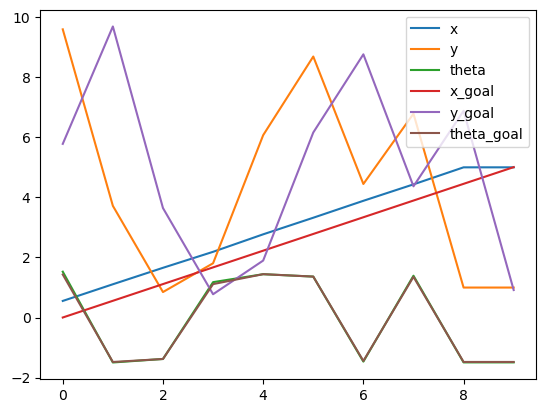

In [128]:
# plot the states, and the global navigation over time  
time = np.arange(0, len(x_goal)) 
print(time)
print(len(X[0,:]))

plt.plot(time, X[0,:], label='x') 
plt.plot(time, X[1,:], label='y') 
plt.plot(time, X[2,:], label='theta') 
plt.plot(time, x_goal, label='x_goal') 
plt.plot(time, y_goal, label='y_goal') 
plt.plot(time, theta_goal, label='theta_goal') 
plt.legend() 
plt.show()